In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

### Collect data

In [ ]:
DATASET_ID = 'koumura_bengalese_finch'

In [ ]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [ ]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'bf.pickle'
df_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/syllable_dfs/koumura_bengalese_finch/bf.pickle')

In [ ]:
syllable_df = pd.read_pickle(df_loc)

In [ ]:
syllable_df[:3]

start_time  end_time labels  sequence_num   indv  indvi        key   rate  \
0       1.158     1.249      0             0  Bird3      0  Bird3_322  32000   
1       1.323     1.404      0             0  Bird3      0  Bird3_322  32000   
2       1.530     1.564      0             0  Bird3      0  Bird3_322  32000   

                                         spectrogram  
0  [[0, 0, 0, 110, 190, 203, 216, 217, 216, 219, ...  
1  [[0, 0, 0, 54, 164, 182, 187, 191, 196, 196, 1...  
2  [[0, 0, 0, 0, 0, 106, 100, 181, 209, 202, 196,...

In [ ]:
len(syllable_df)

214925

In [ ]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

### cluster

In [ ]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [ ]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [ ]:
import hdbscan

In [ ]:
from avgn.visualization.projections import draw_projection_transitions

In [ ]:
from sklearn.decomposition import PCA



Bird3 29470


Bird1 35728


Bird4 26891


Bird6 17653


Bird7 20722


Bird9 19541


Bird2 26015


Bird10 5743


Bird5 20525


Bird0 7652


Bird8 4985


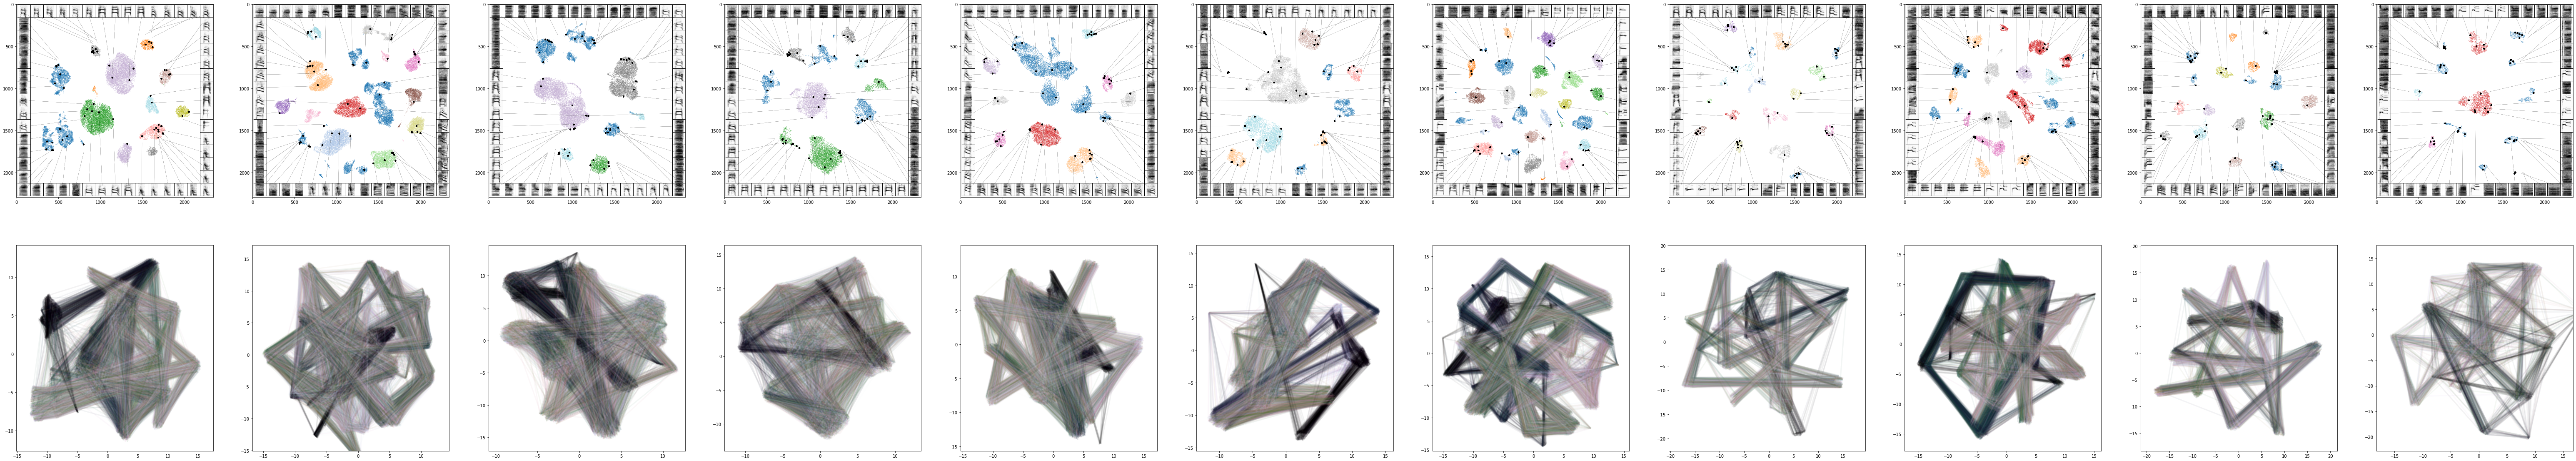

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=len(syllable_df.indv.unique()), figsize=(10*len(syllable_df.indv.unique()), 20))

indv_dfs = {}
for indvi, indv in enumerate(tqdm(syllable_df.indv.unique())):
    #if indv != 'Bird5': continue
    indv_dfs[indv] = syllable_df[syllable_df.indv == indv]
    indv_dfs[indv] = indv_dfs[indv].sort_values(by=["key", "start_time"])
    print(indv, len(indv_dfs[indv]))
    specs = [norm(i) for i in indv_dfs[indv].spectrogram.values]
    
    # sequencing
    indv_dfs[indv]["syllables_sequence_id"] = None
    indv_dfs[indv]["syllables_sequence_pos"] = None
    for ki, key in enumerate(indv_dfs[indv].key.unique()):
        indv_dfs[indv].loc[indv_dfs[indv].key == key, "syllables_sequence_id"] = ki
        indv_dfs[indv].loc[indv_dfs[indv].key == key, "syllables_sequence_pos"] = np.arange(
            np.sum(indv_dfs[indv].key == key)
        )
        
    # umap
    specs_flattened = flatten_spectrograms(specs)
    cuml_umap = cumlUMAP(min_dist=0.5)
    z = list(cuml_umap.fit_transform(specs_flattened))
    indv_dfs[indv]["umap"] = z
    
    pca = PCA(n_components=100)
    z_pca = pca.fit_transform(specs_flattened)
    indv_dfs[indv]["PCA"] = list(z_pca)

    # plot
    scatter_spec(
        np.vstack(z),
        specs,
        column_size=15,
        #x_range = [-5.5,7],
        #y_range = [-10,10],
        pal_color="hls",
        color_points=False,
        enlarge_points=20,
        figsize=(10, 10),
        scatter_kwargs = {
            'labels': list(indv_dfs[indv].labels.values),
            'alpha':0.25,
            's': 1,
            'show_legend': False
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':1,
            'ls':"solid",
            'alpha':0.25,
        },
        draw_lines=True,
        ax= ax[0,indvi]
    );
    
    draw_projection_transitions(
        projections=np.array(list(indv_dfs[indv]['umap'].values)),
        sequence_ids=indv_dfs[indv]["syllables_sequence_id"],
        sequence_pos=indv_dfs[indv]["syllables_sequence_pos"],
        ax=ax[1,indvi],
    )

    

### label

In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
for indv in tqdm(indv_dfs.keys()):
    ### cluster
    
    z_pca = list(indv_dfs[indv]["PCA"].values)

    ### HDBSCAN on PCA
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=int(len(z) * 0.001), # the smallest size we would expect a cluster to be
        min_samples=1, # larger values = more conservative clustering
    )
    clusterer.fit(z_pca);
    indv_dfs[indv]['hdbscan_labels_PCA'] = clusterer.labels_
    
    
    #break
    z = list(indv_dfs[indv]["umap"].values)
    
    # HDBSCAN UMAP
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=int(len(z) * 0.01), # the smallest size we would expect a cluster to be
        min_samples=1, # larger values = more conservative clustering
    )
    clusterer.fit(z);
    indv_dfs[indv]['hdbscan_labels'] = clusterer.labels_
    
    # HDBSCAN 
    specs = [norm(i) for i in indv_dfs[indv].spectrogram.values]
    specs_flattened = flatten_spectrograms(specs)
    
    # kmeans
    # get number of possible states
    n_states = len(indv_dfs[indv].labels.unique())

    kmeans = MiniBatchKMeans(n_clusters = n_states).fit(z)
    indv_dfs[indv]['kmeans_labels'] = kmeans.labels_
    
    # kmeans data
    kmeans = MiniBatchKMeans(n_clusters = n_states).fit(specs_flattened)
    indv_dfs[indv]['kmeans__pix_labels'] = kmeans.labels_

### plot

In [ ]:
for indv in tqdm(indv_dfs.keys()):
    print(indv)
    fig, axs = plt.subplots(ncols=6, figsize=(60, 10))
    draw_projection_transitions(
        projections=np.array(list(indv_dfs[indv]["umap"].values)),
        sequence_ids=indv_dfs[indv]["syllables_sequence_id"],
        sequence_pos=indv_dfs[indv]["syllables_sequence_pos"],
        ax=axs[0],
    )

    for i, lab in enumerate(
        [
            "labels",
            "kmeans_labels",
            "kmeans__pix_labels",
            "hdbscan_labels",
            "hdbscan_labels_PCA"
        ]
    ):

        scatter_spec(
            np.array(list(indv_dfs[indv]["umap"].values)),
            specs = indv_dfs[indv].spectrogram.values,
            column_size=15,
            # x_range = [-5.5,7],
            # y_range = [-10,10],
            pal_color="hls",
            color_points=False,
            enlarge_points=20,
            figsize=(10, 10),
            scatter_kwargs={
                "labels": list(indv_dfs[indv][lab].values),
                "alpha": 0.25,
                "s": 1,
                "show_legend": False,
            },
            matshow_kwargs={"cmap": plt.cm.Greys},
            line_kwargs={"lw": 1, "ls": "solid", "alpha": 0.25},
            draw_lines=True,
            ax=axs[i + 1],
        )
        axs[i + 1].set_title(lab)
    plt.show()

### save dataframes for paper

In [ ]:
ensure_dir(DATA_DIR / "paper_data" / "clustering_umap" / "bengalese_finch_koumura")

In [ ]:
performance_df = pd.DataFrame(columns = ['indv', 'cluster', 'homogeneity', 'completeness', 'V-Measure', 'Adj. MI'])
for indv in tqdm(indv_dfs.keys()):
    break

In [ ]:
indv_dfs[indv][:3]

In [ ]:
indv_dfs[indv].to_pickle(DATA_DIR / "paper_data" / "clustering_umap" / "bengalese_finch_koumura" / "bengalese_finch_koumura.pickle")

### human vs algorithmic labelling similarity

In [ ]:
import sklearn.metrics

In [41]:
performance_df = pd.DataFrame(columns = ['indv', 'cluster', 'homogeneity', 'completeness', 'V-Measure', 'Adj. MI'])
for indv in tqdm(indv_dfs.keys()):
    for cluster in ['hdbscan_labels', 'kmeans__pix_labels', 'kmeans_labels', 'hdbscan_labels_PCA']:
        homogenaity, completeness, v_measure = sklearn.metrics.homogeneity_completeness_v_measure(
            list(indv_dfs[indv].labels), list(indv_dfs[indv][cluster].values)
        )
        ami = sklearn.metrics.adjusted_mutual_info_score(
            list(indv_dfs[indv].labels), list(indv_dfs[indv][cluster].values)
        )
        performance_df.loc[len(performance_df)] = [indv, cluster, homogenaity, completeness, v_measure, ami]

In [42]:
performance_df[:4]

indv             cluster  homogeneity  completeness  V-Measure   Adj. MI
0  Bird3      hdbscan_labels     0.987991      0.816902   0.894338  0.894249
1  Bird3  kmeans__pix_labels     0.952783      0.904566   0.928049  0.928006
2  Bird3       kmeans_labels     0.923125      0.846049   0.882908  0.882839
3  Bird3  hdbscan_labels_PCA     0.989725      0.948753   0.968806  0.968777

In [43]:
performance_df.cluster.unique()

array(['hdbscan_labels', 'kmeans__pix_labels', 'kmeans_labels',
       'hdbscan_labels_PCA'], dtype=object)

In [44]:
summary = performance_df.groupby(['cluster']).describe()

In [50]:
cats = ["homogeneity", "completeness", "V-Measure", "Adj. MI"]
results_latex_df = pd.DataFrame(
    columns=["Homogeneity", "Completeness", "V-Measure", "Adjusted MI"]
)

labs = [['hdbscan_labels', 'HDBSCAN/UMAP'], ['kmeans__pix_labels', 'KMeans'], ['kmeans_labels', 'KMeans/UMAP'], ["hdbscan_labels_PCA", "HDBSCAN/PCA"]]

for lab, name in labs:
    results_latex_df.loc[name] = [
        str(
            round(np.mean(performance_df[performance_df.cluster == lab][i].values),3)
        ).zfill(3)
        + "\u00B1"
        + str(
            round(np.std(performance_df[performance_df.cluster == lab][i].values),3)
        ).zfill(3)
        for i in cats
    ]
results_latex_df = pd.concat([results_latex_df], keys=[''], names=['Koumura et al., ()'])
results_latex_df

Homogeneity Completeness    V-Measure  \
Koumura et al., ()                                                       
                   HDBSCAN/UMAP   0.99±0.006   0.74±0.122  0.841±0.088   
                   KMeans        0.911±0.044   0.85±0.064  0.879±0.051   
                   KMeans/UMAP   0.842±0.116  0.796±0.145  0.817±0.132   
                   HDBSCAN/PCA   0.968±0.036    0.86±0.14  0.902±0.086   

                                 Adjusted MI  
Koumura et al., ()                            
                   HDBSCAN/UMAP   0.84±0.088  
                   KMeans        0.879±0.051  
                   KMeans/UMAP   0.817±0.132  
                   HDBSCAN/PCA   0.902±0.086

In [51]:
results_string = results_latex_df.to_latex(bold_rows=True, escape=False)\
      .replace('>', '$>$')\
.replace('±', '$\pm$')\
      .replace('<', '$<$')\
      .replace('superlabel', '')\
     .replace('\n\\textbf', '\n\midrule\n\\textbf')
print(results_string)


\begin{tabular}{llllll}
\toprule
                   &             &  Homogeneity & Completeness &    V-Measure &  Adjusted MI \\
\midrule
\textbf{Koumura et al., ()} & {} &              &              &              &              \\
\midrule
                   & \textbf{HDBSCAN/UMAP} &   0.99$\pm$0.006 &   0.74$\pm$0.122 &  0.841$\pm$0.088 &   0.84$\pm$0.088 \\
                   & \textbf{KMeans} &  0.911$\pm$0.044 &   0.85$\pm$0.064 &  0.879$\pm$0.051 &  0.879$\pm$0.051 \\
                   & \textbf{KMeans/UMAP} &  0.842$\pm$0.116 &  0.796$\pm$0.145 &  0.817$\pm$0.132 &  0.817$\pm$0.132 \\
                   & \textbf{HDBSCAN/PCA} &  0.968$\pm$0.036 &    0.86$\pm$0.14 &  0.902$\pm$0.086 &  0.902$\pm$0.086 \\
\bottomrule
\end{tabular}



In [52]:
import seaborn as sns
sns.set_context("paper", font_scale=2)

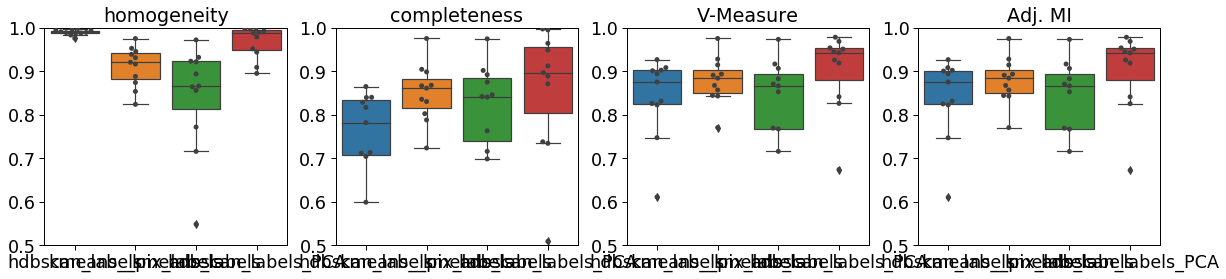

In [49]:
fig, axs = plt.subplots(ncols = 4, figsize=(20,4))

for ci, column in enumerate(["homogeneity", "completeness", "V-Measure", "Adj. MI"]):
    sns.boxplot(x="cluster", y=column, data =performance_df, ax = axs[ci])
    sns.swarmplot(x="cluster", y=column, data =performance_df, ax = axs[ci], color=".25")
    axs[ci].set_ylim([0.5,1])
    #axs[ci].set_xticklabels(['HDBSCAN/UMAP', 'KMeans', 'KMeans/UMAP'], rotation=45, ha='right')
    axs[ci].set_xlabel('')
    axs[ci].set_ylabel('')
    axs[ci].set_title(column)

